# Spatial Interpolation at Biscayne Bay Aquatic Preserve

This document includes Python codes that conduct spatial interpolation for water quality data.

If you are running the code in ArcGIS Notebook, you'll need to install the following packages:

`conda install -c anaconda pandas scikit-learn
conda install -c conda-forge geopandas rasterio contextily
`

**Note: installation of geopandas may take a few hours**

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c).

# Table of Contents:

* [1.Load Data](#load_data)
* [2. Preprocess](#preprocess)
* [3. Combine Data](#read_data)
* [4. Spatial Interpolation of Dissolved Oxygen](#do_interpolate)
    * [4.1 Kriging:Dissolved Oxygen](#do_kriging)
    * [4.2 IDW:Dissolved Oxygen](#do_idw)
    * [4.3 Empirical Bayesian Kriging:Dissolved Oxygen](#do_ebk)
    * [4.4 Validation Summary:Dissolved Oxygen](#do_val_sum) 
* [5. Spatial Interpolation of Salinity](#s_interpolate)
    * [5.1 Kriging:Dissolved Oxygen](#s_kriging)
    * [5.2 IDW:Dissolved Oxygen](#s_idw)
    * [5.3 Empirical Bayesian Kriging:Dissolved Oxygen](#s_ebk)
    * [5.4 Regression Kriging:Dissolved Oxygen](#s_rk)
* [6. Spatial Interpolation of Total Nitrogen](#tn_interpolate)
    * [6.1 Kriging:Total Nitrogen](#tn_kriging)
    * [6.2 IDW:Total Nitrogen](#tn_idw)
    * [6.3 Empirical Bayesian Kriging:Total Nitrogen](#tn_ebk)
    * [6.4 Regression Kriging:Total Nitrogen](#tn_rk)
* [7. Spatial Interpolation of Turbidity](#t_interpolate)
    * [7.1 Kriging:Turbidity](#t_kriging)
    * [7.2 IDW:Turbidity](#t_idw)
    * [7.3 Empirical Bayesian Kriging:Turbidity](#t_ebk)
    * [7.4 Regression Kriging:Turbidity](#t_rk)
* [8. Spatial Interpolation of Secchi Depth](#sd_interpolate)
    * [8.1 Kriging:Secchi Depth](#sd_kriging)
    * [8.2 IDW:Secchi Depth](#sd_idw)
    * [8.3 Empirical Bayesian Kriging:Secchi Depth](#sd_ebk)
    * [8.4 Regression Kriging:Secchi Depth](#sd_rk)

In [11]:
import time, math, os, importlib
import sklearn.metrics  
import arcgisscripting
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg
#import rioxarray as rxr

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from shapely.geometry import box, Polygon, Point
from shapely import wkt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx
#from osgeo import gdal
#from pykrige.ok import OrdinaryKriging

# import arcpy and environmental settings
import arcpy
from arcpy.sa import *
import sys
sys.path.append('..')
import misc.preprocess
import misc.interpolation
arcpy.env.overwriteOutput = True

# 1. Load and Preprocess Data <a class="anchor" id="load_data"></a>

In [12]:
path = "E:/Projects/SEACAR_WQ_Pilot/"
gis_path = path+'GIS_data/'

# path = "D:/Water_Quailty/"
# gis_path = path+'Test02200/'

Preprocess the data and save the preprocessed data in new files

In [13]:
# dfDis, dfCon = misc.preprocess.preprocess(path + r"OEAT_Discrete-2023-Jan-23.csv", 
#                     path + r"OEAT_Continuous_1-2023-Jan-23.csv",
#                     path + r"OEAT_Continuous_2-2023-Jan-23.csv")

# dfDis.to_csv(path + "discrete_0214.csv")
# dfCon.to_csv(path + "continuous_0214.csv")

To save time, we can load the preprocessed "discrete_0214.csv" and "continuous_0214.csv".

In [14]:
#dfDis = pd.read_csv("D:/Water_Quailty/Test0214/discrete_0214.csv")
#dfCon = pd.read_csv("D:/Water_Quailty/Test0214/continuous_0214.csv")

dfDis = pd.read_csv(path + "discrete_0214.csv")
dfCon = pd.read_csv(path + "continuous_0214.csv")

In [15]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
para_ls_ab = ["S","TN","DO","T","SD"]
# Convert full MA names to short names
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island'}

# Convert full MA names to MA name in ORCP_Managed_Areas_Oct2021
dictArea2    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Gasparilla Sound-Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend Seagrasses',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'Guana Tolomato Matanzas NERR','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island Sound'}

dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 

# Set variables of the program
year = "2017"
Area = 'Biscayne Bay Aquatic Preserve'
Para = 'Dissolved Oxygen'
Para_ab = "DO"
SpatialRef = '3086'
b_name = 'bbay'

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'
boundary_shp = gis_path+ '{}.shp'.format(b_name)


# 2. Combine Discrete and Continuous Data <a class="anchor" id="combine"></a>

Combine dis and con dataframes

In [16]:
# ---------------------------- Uncomment in the first run --------------------------
dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_33196\3578914940.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_33196\3578914940.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Skip the preprocessing and load the pre-stored dataframes

In [17]:
# gdfDryAll = pd.read_csv(gis_path+'gdfDryAll{}.csv'.format(year))
# gdfDryAll['geometry'] = gdfDryAll['geometry'].apply(wkt.loads)
# gdfDryAll = gpd.GeoDataFrame(gdfDryAll, crs='epsg:'+SpatialRef)

# gdfWetAll = pd.read_csv(gis_path+'gdfWetAll{}.csv'.format(year))
# gdfWetAll['geometry'] = gdfWetAll['geometry'].apply(wkt.loads)
# gdfWetAll = gpd.GeoDataFrame(gdfWetAll, crs='epsg:'+SpatialRef)

# 3. Read Input Data <a class="anchor" id="read_data"></a>
## 3.1 Load Managed Area Polygon

In [18]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

extentShp = gpd.read_file(boundary_shp )
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

## 3.2 Load Point Shapefiles

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [19]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)

Text(0.5, 1.0, 'Sampling points at Biscayne Bay Aquatic Preserve')

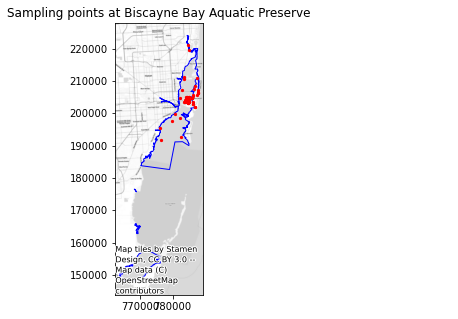

In [20]:
fig, ax = plt.subplots(figsize = (9,5))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))


# 4. Spatial Interpoation of Dissolved Oxygen <a class="anchor" id="do_interpolate"></a>

## 4.1 Ordinary Kriging: Dissolved Oxygen <a class="anchor" id="do_kriging"></a>

Run Oridinary Kriging for dry season data

In [21]:
importlib.reload(misc.interpolation)
importlib.reload(misc)

season, method, value_field, mask = 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryOKStat)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetOKStat)

Start the interpolation with the OK method


'Validation of the OK method in the dry season in 2017:'

,meanError,meanStandardizedError,rootMeanSquareError
OK,0.004165,0.021876,1.323614


Start the interpolation with the OK method


'Validation of the OK method in the wet season in 2017:'

,meanError,meanStandardizedError,rootMeanSquareError
OK,0.006634,-0.124948,1.21522


Plot the interpolation result

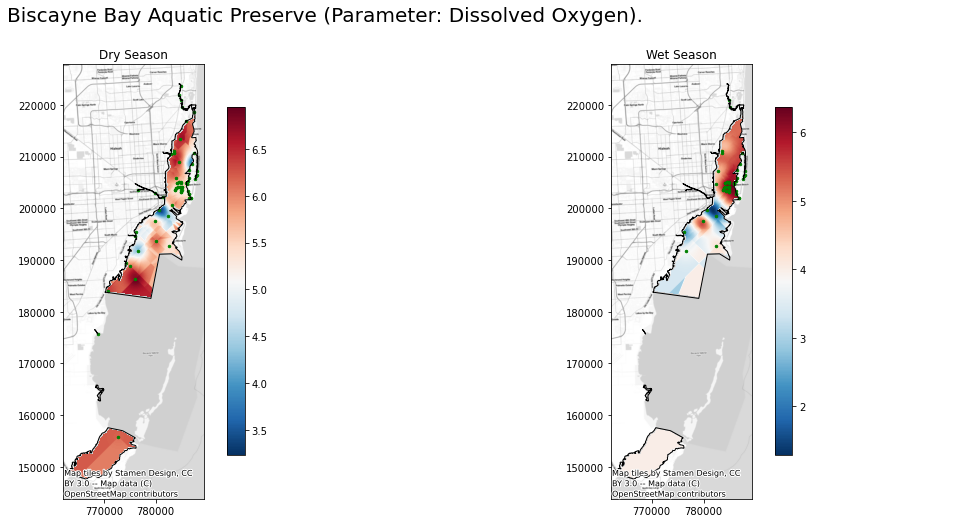

In [22]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK, 'Wet Season', axes[1], fig)

## 4.2 Inverse Distance Weighting (IDW): Dissolved Oxygen <a class="anchor" id="do_idw"></a>

Run IDW for both wet and dry seasons

In [23]:
season, method, value_field, mask = 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW, dryIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryIDWStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW, wetIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)
    
display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetIDWStat)

Start the interpolation with the IDW method
--- Time lapse: 11.23753547668457 seconds ---


'Validation of the IDW method in the dry season in 2017:'

,meanError,meanStandardizedError,rootMeanSquareError
IDW,0.0121,NaN,1.1801


Start the interpolation with the IDW method
--- Time lapse: 11.454267978668213 seconds ---


'Validation of the IDW method in the wet season in 2017:'

,meanError,meanStandardizedError,rootMeanSquareError
IDW,0.0856,NaN,1.006


Plot the interpolation result

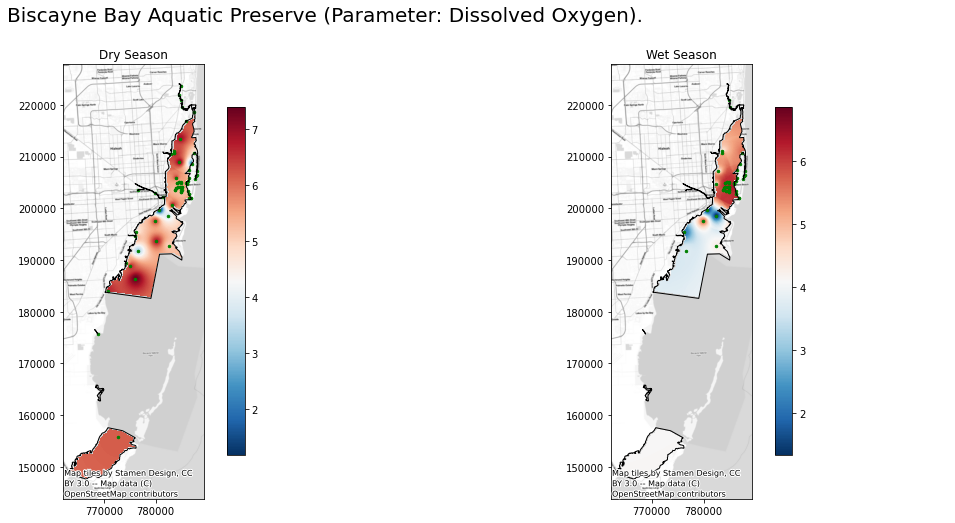

In [24]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW, 'Wet Season', axes[1],fig)


## 4.3 Empirical Bayesian Kriging (EBK) <a class="anchor" id="do_ebk"></a>

Run EBK for wet and dry seasons

In [25]:
season, method, value_field, mask = 'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK, dryEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = value_field, 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryEBKStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK, wetEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = 'ResultValu', 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetEBKStat)

Start the interpolation with the EBK method
--- Time lapse: 56.53930926322937 seconds ---


'Validation of the EBK method in the dry season in 2017:'

,meanError,meanStandardizedError,rootMeanSquareError
EBK,0.0113,0.0055,1.1638


Start the interpolation with the EBK method
--- Time lapse: 45.680153369903564 seconds ---


'Validation of the EBK method in the wet season in 2017:'

,meanError,meanStandardizedError,rootMeanSquareError
EBK,0.013,0.003,0.9244


Plot interpolation results

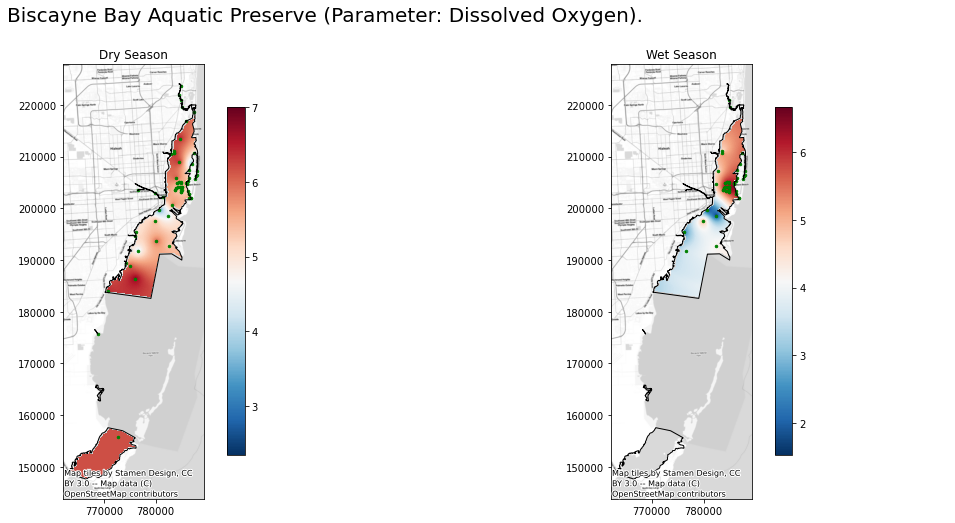

In [26]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK, 'Wet Season', axes[1],fig)


## 4.4 Validation summary <a class="anchor" id="do_ebk_sum"></a>

In [27]:
sumStatDry1   = pd.concat([dryOKStat,dryIDWStat,dryEBKStat])
print("Summary of interpolation assessment in dry season data")
sumStatDry1

Summary of interpolation assessment in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
OK,0.004165,0.021876,1.323614
IDW,0.012100,NaN,1.180100
EBK,0.011300,0.005500,1.163800


In [28]:
sumStatWet1 = pd.concat([wetOKStat,wetIDWStat,wetEBKStat])
print("Summary of interpolation assessment in wet season data")
sumStatWet1

Summary of interpolation assessment in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
OK,0.006634,-0.124948,1.21522
IDW,0.085600,NaN,1.00600
EBK,0.013000,0.003000,0.92440


# 5. Spatial Interpolation of Salinity <a class="anchor" id="s_interpolate"></a>

In [29]:

# dfDis["timestamp"]=  pd.to_datetime(dfDis['SampleDate'])
# dfCon["timestamp"]=  pd.to_datetime(dfCon['SampleDate'])

# dfDryMean, gdfDryAll = combine_dis_con_dry(dfDis,dfCon,year)
# dfWetMean, gdfWetAll = combine_dis_con_wet(dfDis,dfCon,year)

Para, Para_ab = 'Salinity', 'S'

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_33196\3782005919.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_33196\3782005919.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


In [30]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Biscayne Bay Aquatic Preserve')

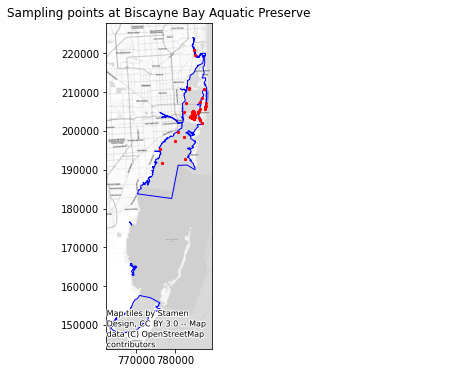

In [31]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 5.1 Ordinary Kriging (Salinity) <a class="anchor" id="s_ok"></a>

In [32]:
season, method, value_field, mask = 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryOKStat)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetOKStat)

Start the interpolation with the OK method


'Validation of the OK method in the dry season in 2017:'

,meanError,meanStandardizedError,rootMeanSquareError
OK,0.291597,0.107337,4.630851


Start the interpolation with the OK method


'Validation of the OK method in the wet season in 2017:'

,meanError,meanStandardizedError,rootMeanSquareError
OK,-0.048762,-0.014305,2.476175


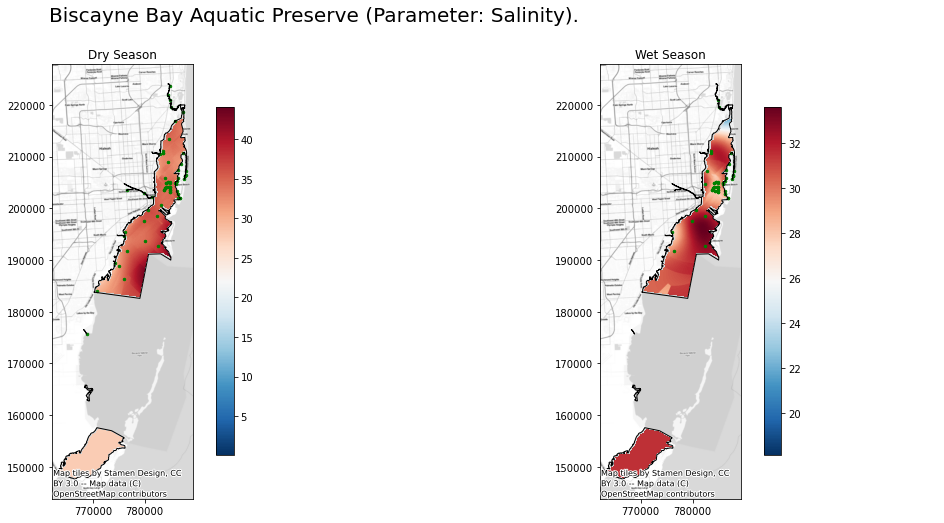

In [33]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK, 'Wet Season', axes[1], fig)

## 5.2 Inverse Distance Weighting (IDW): Salinity <a class="anchor" id="s_idw"></a>

Run IDW for both wet and dry seasons

In [34]:
season, method, value_field, mask = 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW, dryIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryIDWStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW, wetIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)
    
display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetIDWStat)

Start the interpolation with the IDW method
--- Time lapse: 12.371534824371338 seconds ---


'Validation of the IDW method in the dry season in 2017:'

,meanError,meanStandardizedError,rootMeanSquareError
IDW,0.6299,NaN,5.1363


Start the interpolation with the IDW method
--- Time lapse: 13.554481267929077 seconds ---


'Validation of the IDW method in the wet season in 2017:'

,meanError,meanStandardizedError,rootMeanSquareError
IDW,-0.2999,NaN,1.5958


Plot the interpolation result

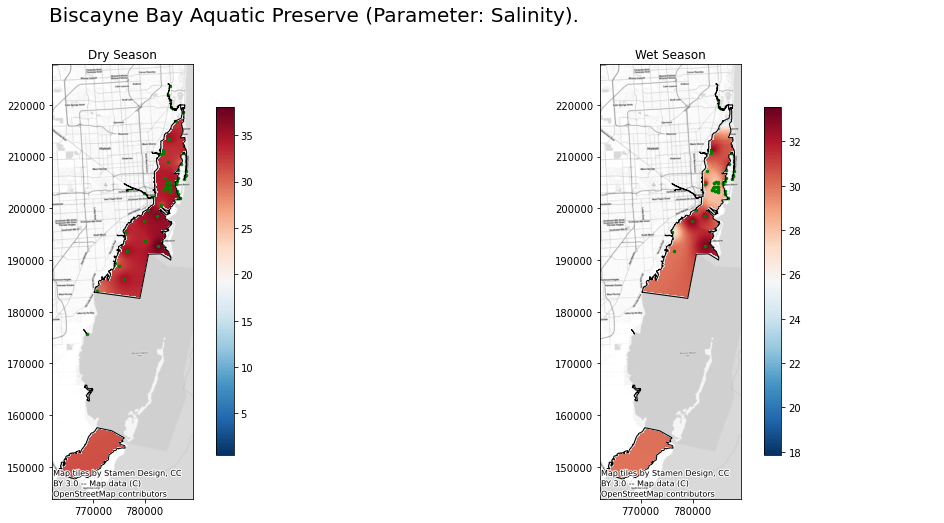

In [35]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW, 'Wet Season', axes[1],fig)

## 5.3 Empirical Bayesian Kriging (EBK): Salinity <a class="anchor" id="s_ebk"></a>

Run EBK for wet and dry seasons

In [36]:
season, method, value_field, mask = 'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK, dryEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = value_field, 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryEBKStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK, wetEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = 'ResultValu', 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetEBKStat)

Start the interpolation with the EBK method
--- Time lapse: 51.66006016731262 seconds ---


'Validation of the EBK method in the dry season in 2017:'

,meanError,meanStandardizedError,rootMeanSquareError
EBK,0.4555,0.0492,4.7361


Start the interpolation with the EBK method
--- Time lapse: 46.21702790260315 seconds ---


'Validation of the EBK method in the wet season in 2017:'

,meanError,meanStandardizedError,rootMeanSquareError
EBK,-0.0908,-0.0421,1.5662


Plot interpolation results

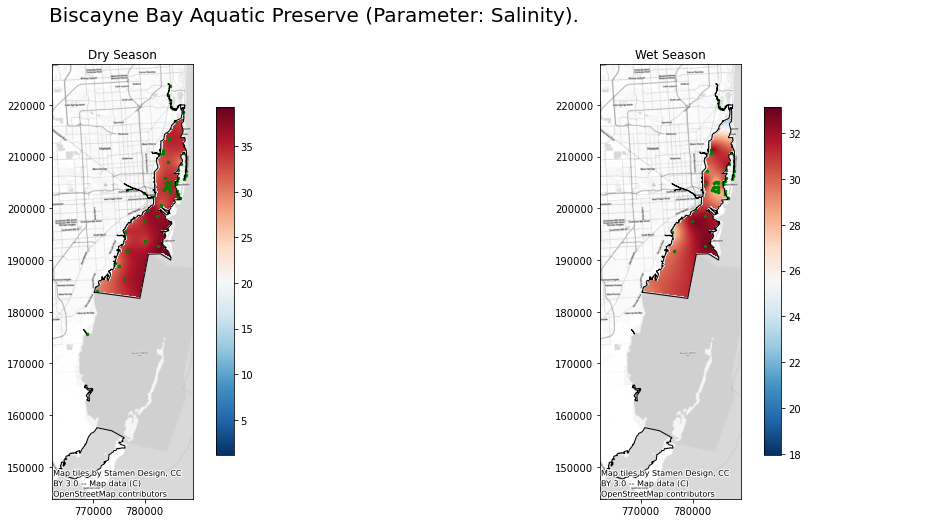

In [37]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK, 'Wet Season', axes[1],fig)

## 5.4 Validation Summary: Salinity <a class="anchor" id="s_val_sum"></a>

In [38]:
sumStatDry2   = pd.concat([dryOKStat,dryIDWStat,dryEBKStat])
print("Summary of interpolation assessment in dry season data")
sumStatDry2

Summary of interpolation assessment in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
OK,0.291597,0.107337,4.630851
IDW,0.629900,NaN,5.136300
EBK,0.455500,0.049200,4.736100


In [39]:
sumStatWet2 = pd.concat([wetOKStat,wetIDWStat,wetEBKStat])
print("Summary of interpolation assessment in wet season data")
sumStatWet2

Summary of interpolation assessment in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
OK,-0.048762,-0.014305,2.476175
IDW,-0.299900,NaN,1.595800
EBK,-0.090800,-0.042100,1.566200


# 6. Spatial Interpolation of Total Nitrogen <a class="anchor" id="tn_interpolate"></a>

Select and preview data

In [40]:
year,Para,Para_ab = "2014", 'Total Nitrogen', "TN"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_33196\4272777287.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_33196\4272777287.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


In [41]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Biscayne Bay Aquatic Preserve')

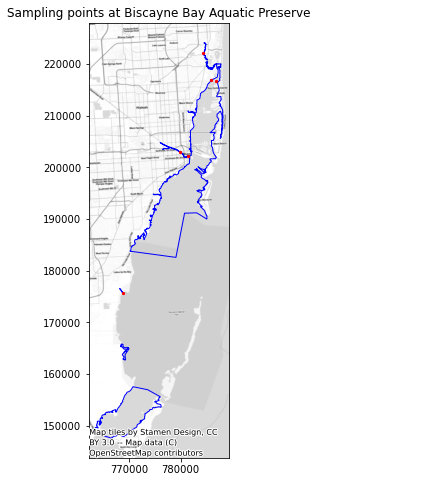

In [42]:
fig, ax = plt.subplots(figsize = (9,8))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 6.1 Ordinary Kriging: Total Nitrogen <a class="anchor" id="tn_kriging"></a>

In [43]:
season, method, value_field, mask = 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryOKStat)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetOKStat)

Start the interpolation with the OK method


'Validation of the OK method in the dry season in 2014:'

,meanError,meanStandardizedError,rootMeanSquareError
OK,-0.031649,-0.045305,0.221127


Start the interpolation with the OK method


'Validation of the OK method in the wet season in 2014:'

,meanError,meanStandardizedError,rootMeanSquareError
OK,-0.244446,-0.288189,0.537777


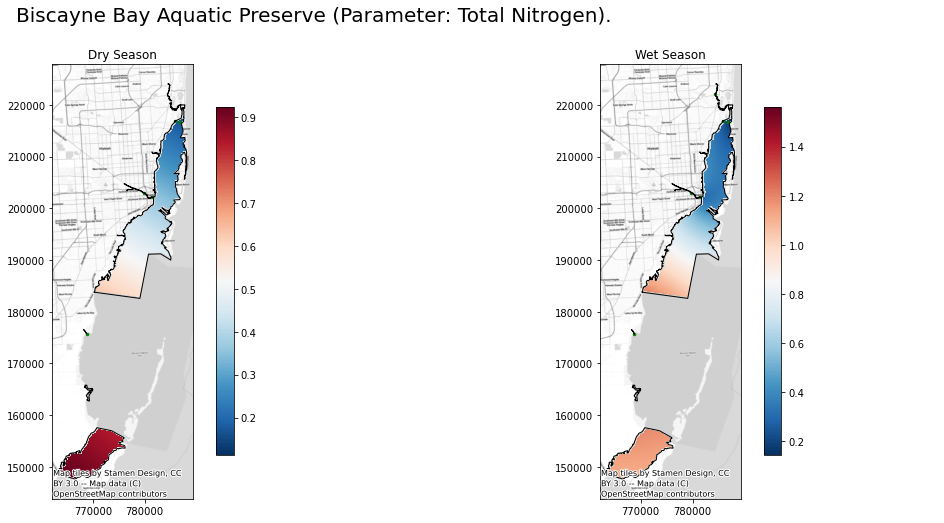

In [44]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK, 'Wet Season', axes[1], fig)

## 6.2 Inverse Distance Weighting: Total Nitrogen <a class="anchor" id="tn_idw"></a>

In [45]:
season, method, value_field, mask = 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW, dryIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryIDWStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW, wetIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)
    
display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetIDWStat)

Start the interpolation with the IDW method
--- Time lapse: 13.353559017181396 seconds ---


'Validation of the IDW method in the dry season in 2014:'

,meanError,meanStandardizedError,rootMeanSquareError
IDW,-0.0972,NaN,0.3431


Start the interpolation with the IDW method
--- Time lapse: 13.147501468658447 seconds ---


'Validation of the IDW method in the wet season in 2014:'

,meanError,meanStandardizedError,rootMeanSquareError
IDW,-0.2784,NaN,0.552


C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


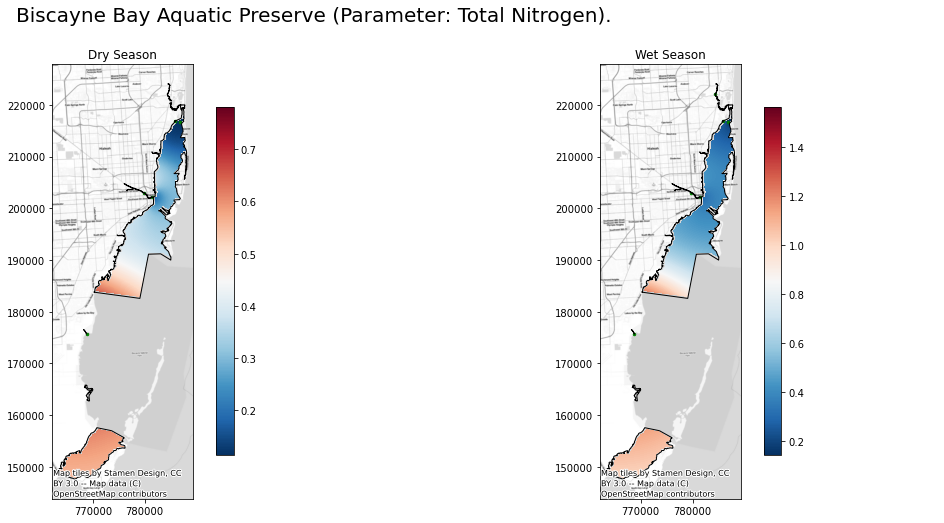

In [46]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW, 'Wet Season', axes[1],fig)

## 6.3 Empirical Bayesian Kriging: Total Nitrogen <a class="anchor" id="tn_ebk"></a>

In [47]:
season, method, value_field, mask = 'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK, dryEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = value_field, 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryEBKStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK, wetEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = 'ResultValu', 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetEBKStat)

Start the interpolation with the EBK method


ExecuteError: ERROR 040039: Not enough data to compute method.
Failed to execute (EmpiricalBayesianKriging).


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK, 'Wet Season', axes[1],fig)

## 6.4 Validation Summary: Total Nitrogen <a class="anchor" id="tn_rk_val"></a>

In [ ]:
sumStatDry3   = pd.concat([dryOKStat,dryIDWStat,dryEBKStat])
print("Summary of interpolation assessment in dry season data")
sumStatDry3

In [ ]:
sumStatWet3 = pd.concat([wetOKStat,wetIDWStat,wetEBKStat])
print("Summary of interpolation assessment in wet season data")
sumStatWet3

# 7. Spatial Interpolation of Turbidity <a class="anchor" id="t_interpolate"></a>

Select and preview data

In [ ]:
year,Para,Para_ab = "2014", 'Turbidity', "T"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

In [ ]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

In [ ]:
fig, ax = plt.subplots(figsize = (9,8))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 7.1 Ordinary Kriging: Turbidity <a class="anchor" id="t_kriging"></a>

In [ ]:
season, method, value_field, mask = 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryOKStat)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetOKStat)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK, 'Wet Season', axes[1], fig)

## 7.2 Inverse Distance Weighting: Turbidity <a class="anchor" id="t_idw"></a>

In [ ]:
season, method, value_field, mask = 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW, dryIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryIDWStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW, wetIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)
    
display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetIDWStat)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW, 'Wet Season', axes[1],fig)

## 7.3 Empirical Bayesian Kriging: Turbidity <a class="anchor" id="t_ebk"></a>

In [ ]:
season, method, value_field, mask = 'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK, dryEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = value_field, 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryEBKStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK, wetEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = 'ResultValu', 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetEBKStat)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK, 'Wet Season', axes[1],fig)

## 7.4 Validation Summary: Turbidity <a class="anchor" id="t_rk_val"></a>

In [ ]:
sumStatDry4   = pd.concat([dryOKStat,dryIDWStat,dryEBKStat])
print("Summary of interpolation assessment in dry season data")
sumStatDry4

In [ ]:
sumStatWet4 = pd.concat([wetOKStat,wetIDWStat,wetEBKStat])
print("Summary of interpolation assessment in wet season data")
sumStatWet4

# 8. Spatial Interpolation of Secchi Depth <a class="anchor" id="sd_interpolate"></a>

Select and preview data

In [ ]:
year,Para,Para_ab = "2015", 'Secchi Depth', "SD"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

In [ ]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

In [ ]:
fig, ax = plt.subplots(figsize = (9,8))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 8.1 Ordinary Kriging: Secchi Depth <a class="anchor" id="sd_kriging"></a>

In [ ]:
season, method, value_field, mask = 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryOKStat)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetOKStat)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK, 'Wet Season', axes[1], fig)

## 8.2 Inverse Distance Weighting: Secchi Depth <a class="anchor" id="t_idw"></a>

In [ ]:
season, method, value_field, mask = 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW, dryIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryIDWStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW, wetIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)
    
display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetIDWStat)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW, 'Wet Season', axes[1],fig)

## 8.3 Empirical Bayesian Kriging: Secchi Depth <a class="anchor" id="sd_ebk"></a>

In [ ]:
season, method, value_field, mask = 'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK, dryEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = value_field, 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryEBKStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK, wetEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = 'ResultValu', 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetEBKStat)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK, 'Wet Season', axes[1],fig)

## 8.4 Validation Summary: Secchi Depth <a class="anchor" id="sd_rk_val"></a>

In [ ]:
sumStatDry5   = pd.concat([dryOKStat,dryIDWStat,dryEBKStat])
print("Summary of interpolation assessment in dry season data")
sumStatDry5

In [ ]:
sumStatWet5 = pd.concat([wetOKStat,wetIDWStat,wetEBKStat])
print("Summary of interpolation assessment in wet season data")
sumStatWet5